In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import importlib
import torch
import pandas as pd
import os
import sys
import json
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from recover.utils.utils import get_tensor_dataset
import reservoir as rdl
from copy import deepcopy
import numpy as np
from tqdm import tqdm

# sns.set_theme()
sns.set_style("ticks")

## Active Learning performance

In [2]:
logdir_list = ["/Users/paul/PycharmProjects/RECOVERcoalition/Recover/RayLogs/active_learning_UCB"]

In [3]:
All_results = None

for logdir in logdir_list:
    for directory in os.listdir(logdir):
        if directory.startswith("Active"):
            f = open(os.path.join(logdir, directory, "params.json"))
            params = json.load(f)
            f.close()

            progress = pd.read_csv(os.path.join(logdir, directory, "progress.csv"))

            result = pd.DataFrame(progress['top'])
            result['query_true_syn_mean'] = progress['query_true_syn_mean']
            result['n_unique_drugs_in_query'] = progress['n_unique_drugs_in_query']
            result['query_true_syn_quantile_0.5'] = progress['query_true_syn_quantile_0.5']
            result['query_true_syn_quantile_0.0'] = progress['query_true_syn_quantile_0.0']
            result['query_true_syn_quantile_1.0'] = progress['query_true_syn_quantile_1.0']


            result["n_epoch_between_queries"] = params["n_epoch_between_queries"]
            result["acquire_n_at_a_time"] = params["acquire_n_at_a_time"]
            result["n_initial"] = params["n_initial"]
            result["patience_max"] = params["patience_max"]
            result['load_model_weights'] = params['load_model_weights']
            result['acquisition'] = params['acquisition'].split('.')[-1][:-2]
            result['n_initial'] = params['n_initial']
            result['seed'] = params['seed']
            result['cell_line'] = params['cell_line']
            result['kappa'] = params['kappa']
            result['iterations'] = range(len(result))
            result['val_set_prop'] = params['val_set_prop']
            result['target'] = params['target']

            if All_results is None:
                All_results = result
            else:
                All_results = pd.concat((All_results, result))

In [4]:
All_results = All_results.dropna()
All_results = All_results.reset_index()

All_results = All_results.rename(columns={"top": "Cumulative proportion of top 1% queried", 
                                          "iterations": "Iteration",
                                          "acquisition": "Acquisition",
                                         "query_true_syn_mean": "Average of true synergies in the query"})

mapping = {"RandomAcquisition": "Brute-Force", "GreedyAcquisition": "Greedy acquisition", "UCB": "UCB acquisition"}

All_results["Acquisition"] = All_results["Acquisition"].apply(lambda s: mapping[s])

All_results["Iteration"] = All_results["Iteration"].apply(lambda s: s + 2)

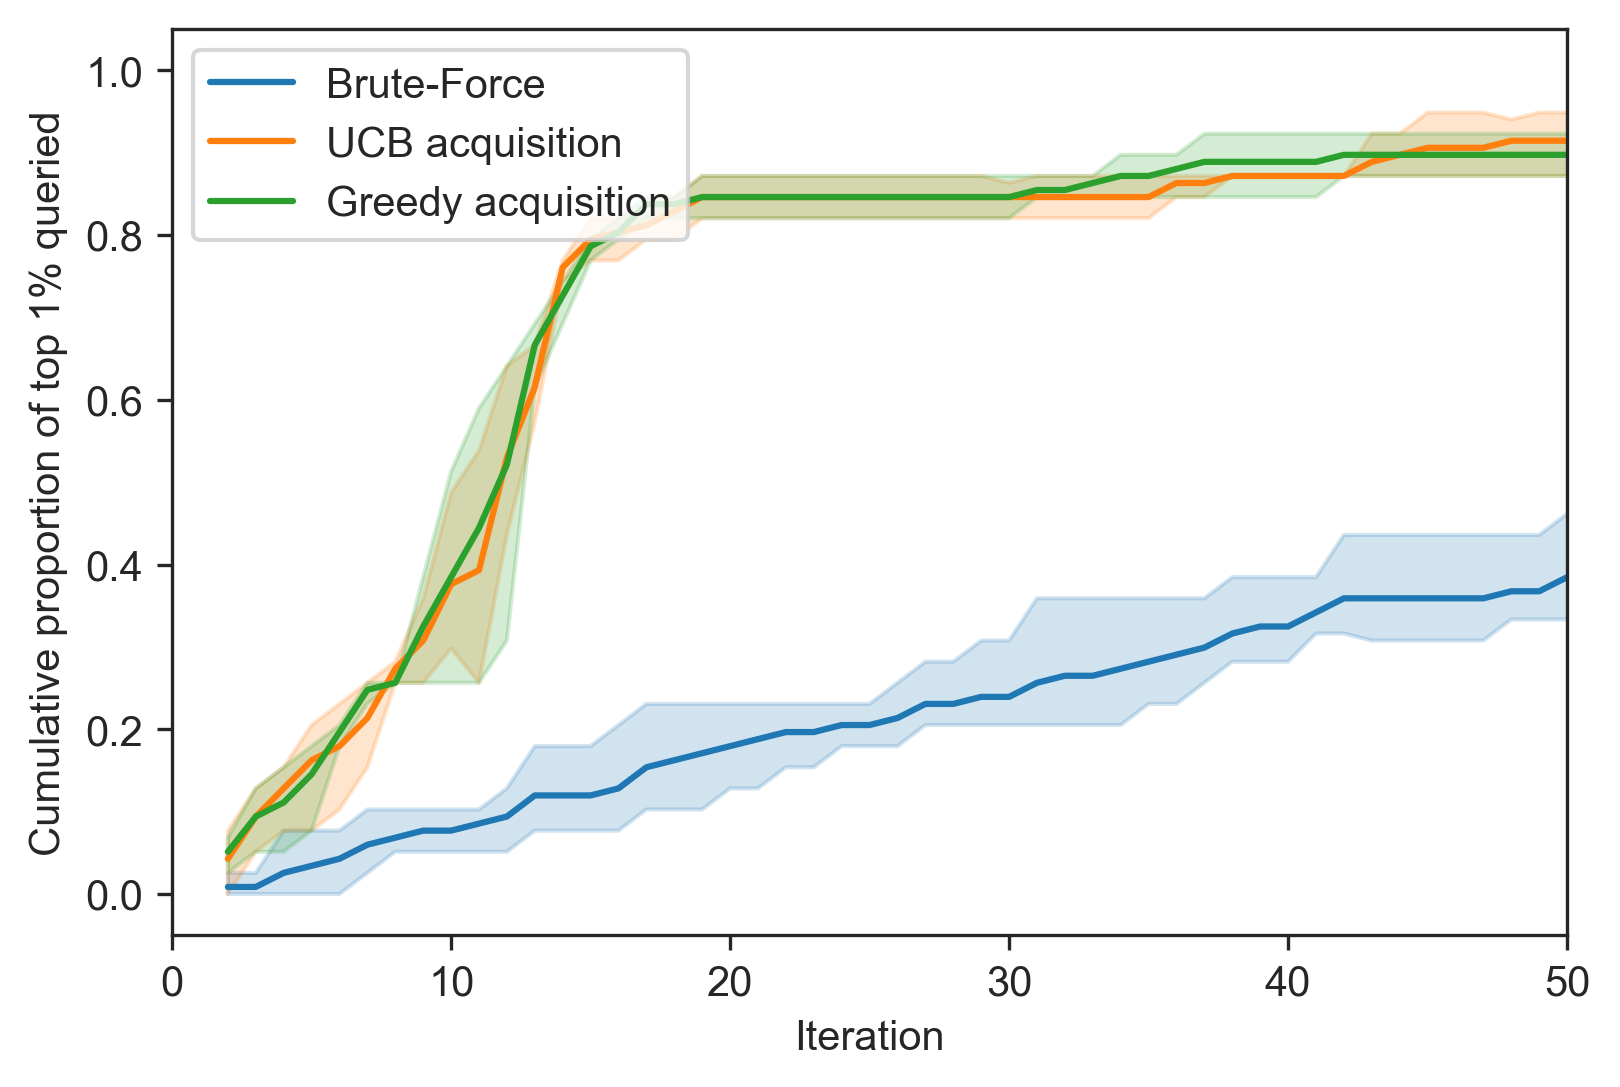

In [5]:
plt.figure(dpi=300)
sns.lineplot(data=All_results, x="Iteration", y='Cumulative proportion of top 1% queried', hue="Acquisition")
plt.xlim(0, 50)
plt.legend(loc='upper left')
plt.show()

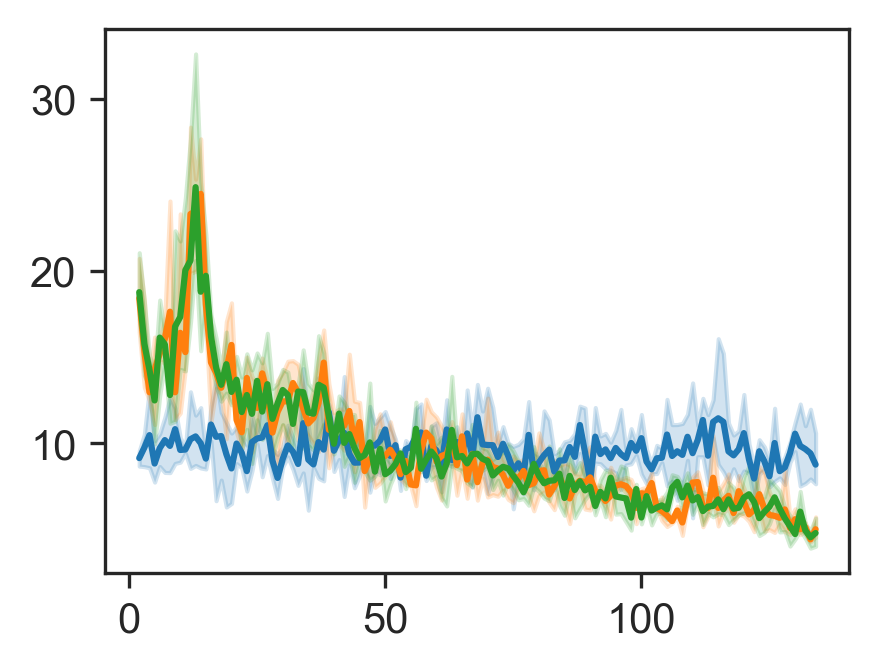

In [6]:
plt.figure(figsize=(3.2, 2.4), dpi=300)
sns.lineplot(data=All_results, x="Iteration", y="Average of true synergies in the query", hue="Acquisition")
# plt.xlim(0, 20)
plt.xlabel("")
plt.ylabel("")
plt.legend().remove()
plt.show()

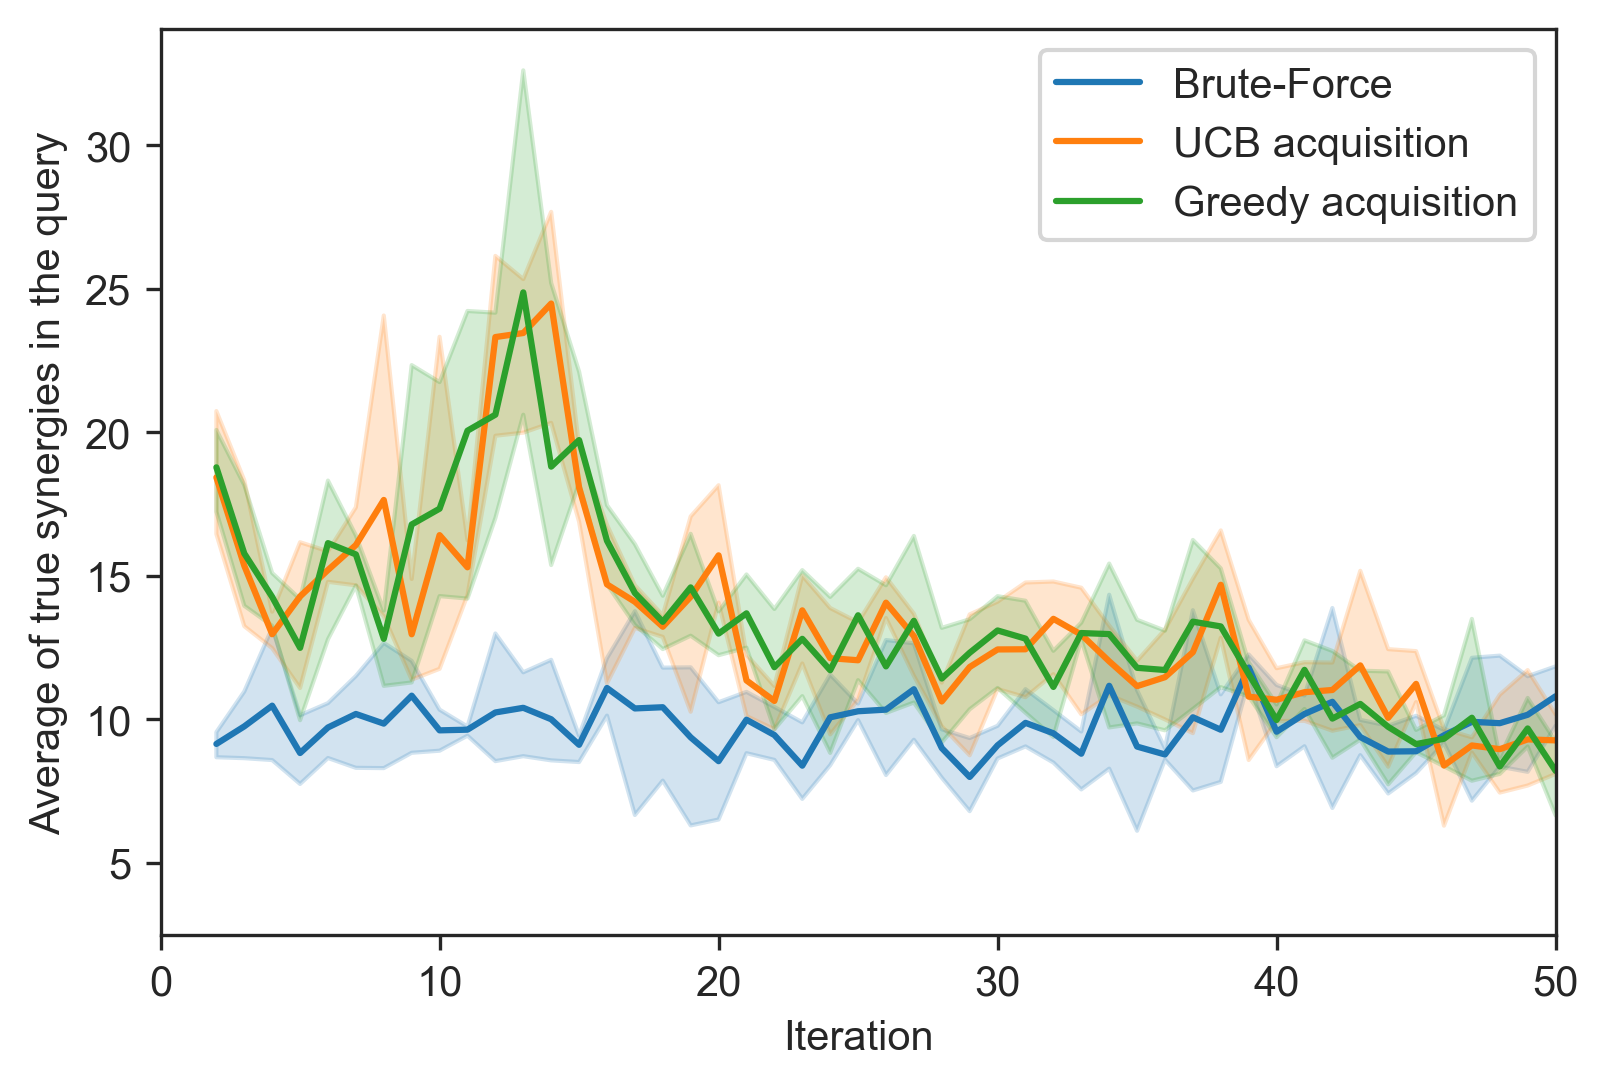

In [7]:
plt.figure(dpi=300)
sns.lineplot(data=All_results, x="Iteration", y="Average of true synergies in the query", hue="Acquisition")
plt.xlim(0, 50)
plt.legend(loc='upper right')
plt.show()

## Active learning with pretraining (Ensemble)

In [8]:
logdir_list = ["/Users/paul/PycharmProjects/RECOVERcoalition/Recover/RayLogs/active_learning"
               "_pretraining_Feb_ens"]

In [9]:
All_results = None

for logdir in logdir_list:
    for directory in os.listdir(logdir):
        if directory.startswith("Active"):
            f = open(os.path.join(logdir, directory, "params.json"))
            params = json.load(f)
            f.close()

            progress = pd.read_csv(os.path.join(logdir, directory, "progress.csv"))

            result = pd.DataFrame(progress['top'])
            result['query_true_syn_mean'] = progress['query_true_syn_mean']
            result['n_unique_drugs_in_query'] = progress['n_unique_drugs_in_query']
            result['query_true_syn_quantile_0.5'] = progress['query_true_syn_quantile_0.5']
            result['query_true_syn_quantile_0.0'] = progress['query_true_syn_quantile_0.0']
            result['query_true_syn_quantile_1.0'] = progress['query_true_syn_quantile_1.0']


            result["n_epoch_between_queries"] = params["n_epoch_between_queries"]
            result["acquire_n_at_a_time"] = params["acquire_n_at_a_time"]
            result["n_initial"] = params["n_initial"]
            result["patience_max"] = params["patience_max"]
            result['load_model_weights'] = params['load_model_weights']
            result['acquisition'] = params['acquisition'].split('.')[-1][:-2]
            result['n_initial'] = params['n_initial']
            result['seed'] = params['seed']
            result['kappa'] = params['kappa']
            result['iterations'] = range(len(result))
            result['val_set_prop'] = params['val_set_prop']
            result['target'] = params['target']

            if All_results is None:
                All_results = result
            else:
                All_results = pd.concat((All_results, result))

In [10]:
All_results = All_results.dropna()
All_results = All_results.reset_index()

All_results = All_results.rename(columns={"top": 'Cumulative proportion of top 1% queried', 
                                          "acquisition": "Acquisition",
                                          "iterations": "Iteration",
                                         "query_true_syn_mean": "Average of true synergies in the query",
                                         "load_model_weights": "Pretrained"})

mapping = {"RandomAcquisition": "Brute-Force", "GreedyAcquisition": "Greedy acquisition", "UCB": "UCB acquisition"}

All_results["Acquisition"] = All_results["Acquisition"].apply(lambda s: mapping[s])
All_results["Iteration"] = All_results["Iteration"].apply(lambda s: s + 2)

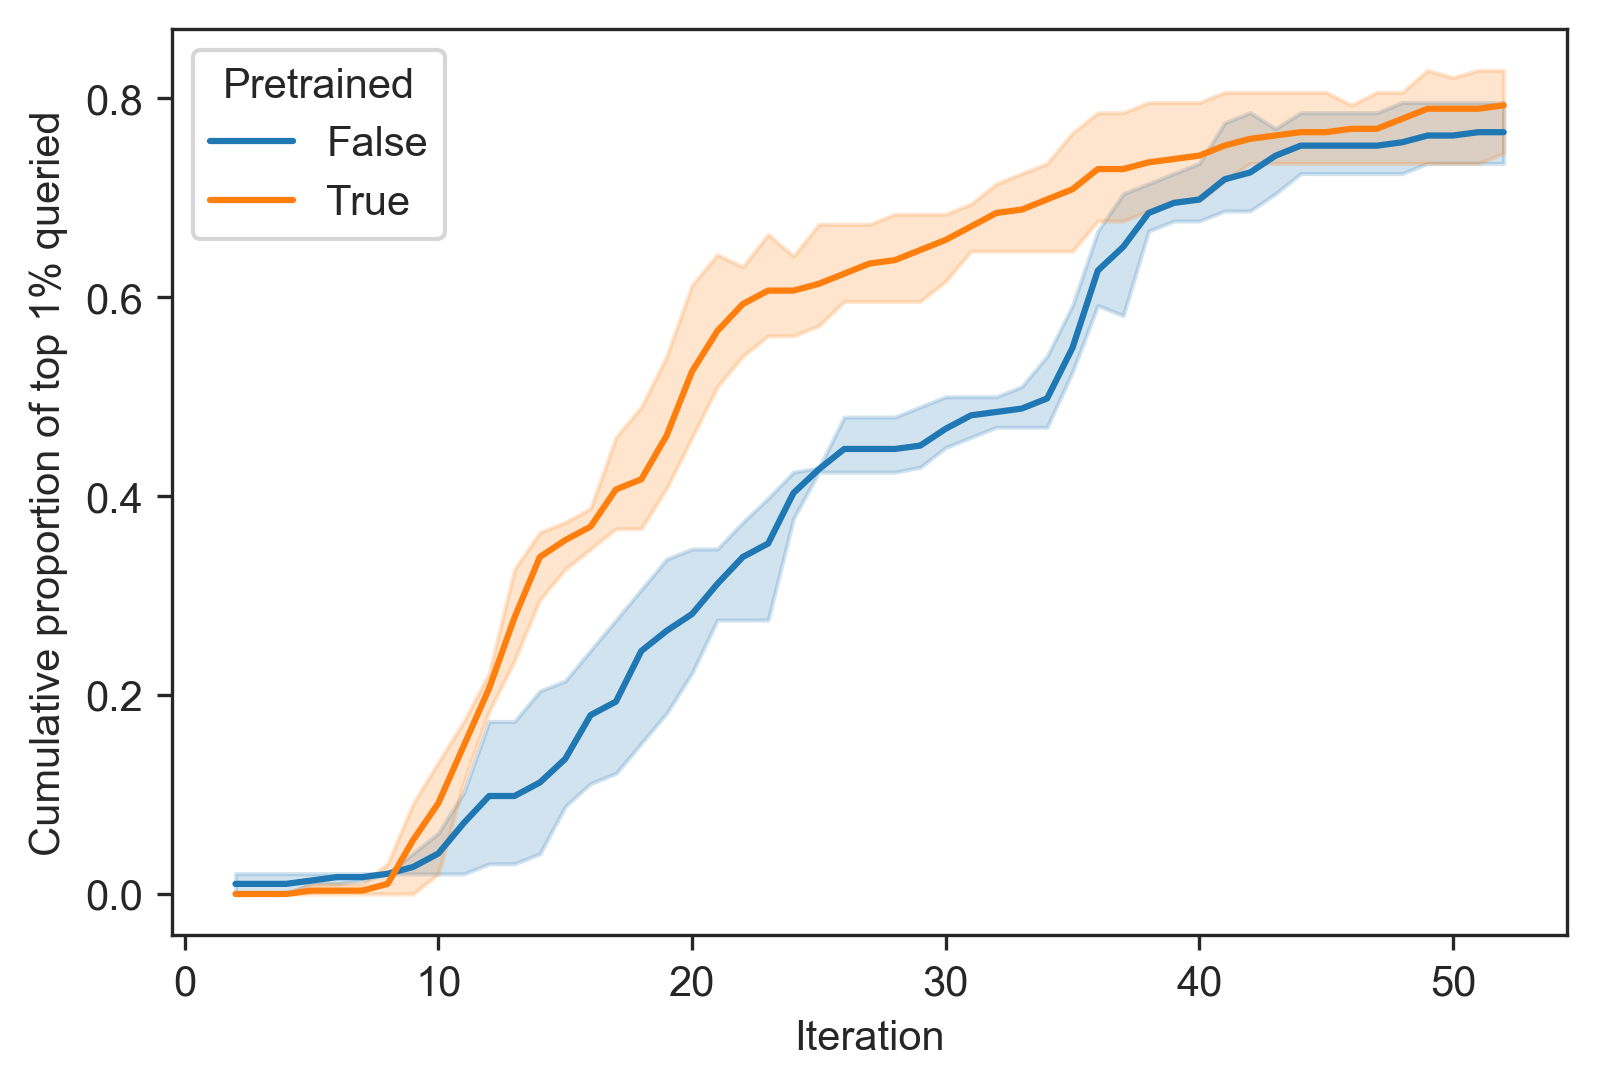

In [11]:
plt.figure(dpi=300)

# All_results = All_results[All_results["Pretrained"].apply(lambda p: not(p))]

sns.lineplot(data=All_results, x="Iteration", 
             y='Cumulative proportion of top 1% queried', hue="Pretrained")
# plt.xlim(0, 20)
plt.show()

## Active Learning with pretraining (DEUP)

In [12]:
logdir_list = ["/Users/paul/PycharmProjects/RECOVERcoalition/Recover/RayLogs/active_learning_pretraining_Feb"]

In [13]:
All_results = None

for logdir in logdir_list:
    for directory in os.listdir(logdir):
        if directory.startswith("Active"):
            f = open(os.path.join(logdir, directory, "params.json"))
            params = json.load(f)
            f.close()

            progress = pd.read_csv(os.path.join(logdir, directory, "progress.csv"))

            result = pd.DataFrame(progress['top'])
            result['query_true_syn_mean'] = progress['query_true_syn_mean']
            result['n_unique_drugs_in_query'] = progress['n_unique_drugs_in_query']
            result['query_true_syn_quantile_0.5'] = progress['query_true_syn_quantile_0.5']
            result['query_true_syn_quantile_0.0'] = progress['query_true_syn_quantile_0.0']
            result['query_true_syn_quantile_1.0'] = progress['query_true_syn_quantile_1.0']


            result["n_epoch_between_queries"] = params["n_epoch_between_queries"]
            result["acquire_n_at_a_time"] = params["acquire_n_at_a_time"]
            result["n_initial"] = params["n_initial"]
            result["patience_max"] = params["patience_max"]
            result['load_model_weights'] = params['load_model_weights']
            result['acquisition'] = params['acquisition'].split('.')[-1][:-2]
            result['n_initial'] = params['n_initial']
            result['seed'] = params['seed']
            result['kappa'] = params['kappa']
            result['iterations'] = range(len(result))
            result['val_set_prop'] = params['val_set_prop']
            result['target'] = params['target']

            if All_results is None:
                All_results = result
            else:
                All_results = pd.concat((All_results, result))

In [14]:
All_results = All_results.dropna()
All_results = All_results.reset_index()

All_results = All_results.rename(columns={"top": 'Cumulative proportion of top 1% queried', 
                                          "acquisition": "Acquisition",
                                          "iterations": "Iteration",
                                         "query_true_syn_mean": "Average of true synergies in the query",
                                         "load_model_weights": "Pretrained"})

mapping = {"RandomAcquisition": "Brute-Force", "GreedyAcquisition": "Greedy acquisition", "UCB": "UCB acquisition"}

All_results["Acquisition"] = All_results["Acquisition"].apply(lambda s: mapping[s])
All_results["Iteration"] = All_results["Iteration"].apply(lambda s: s + 2)

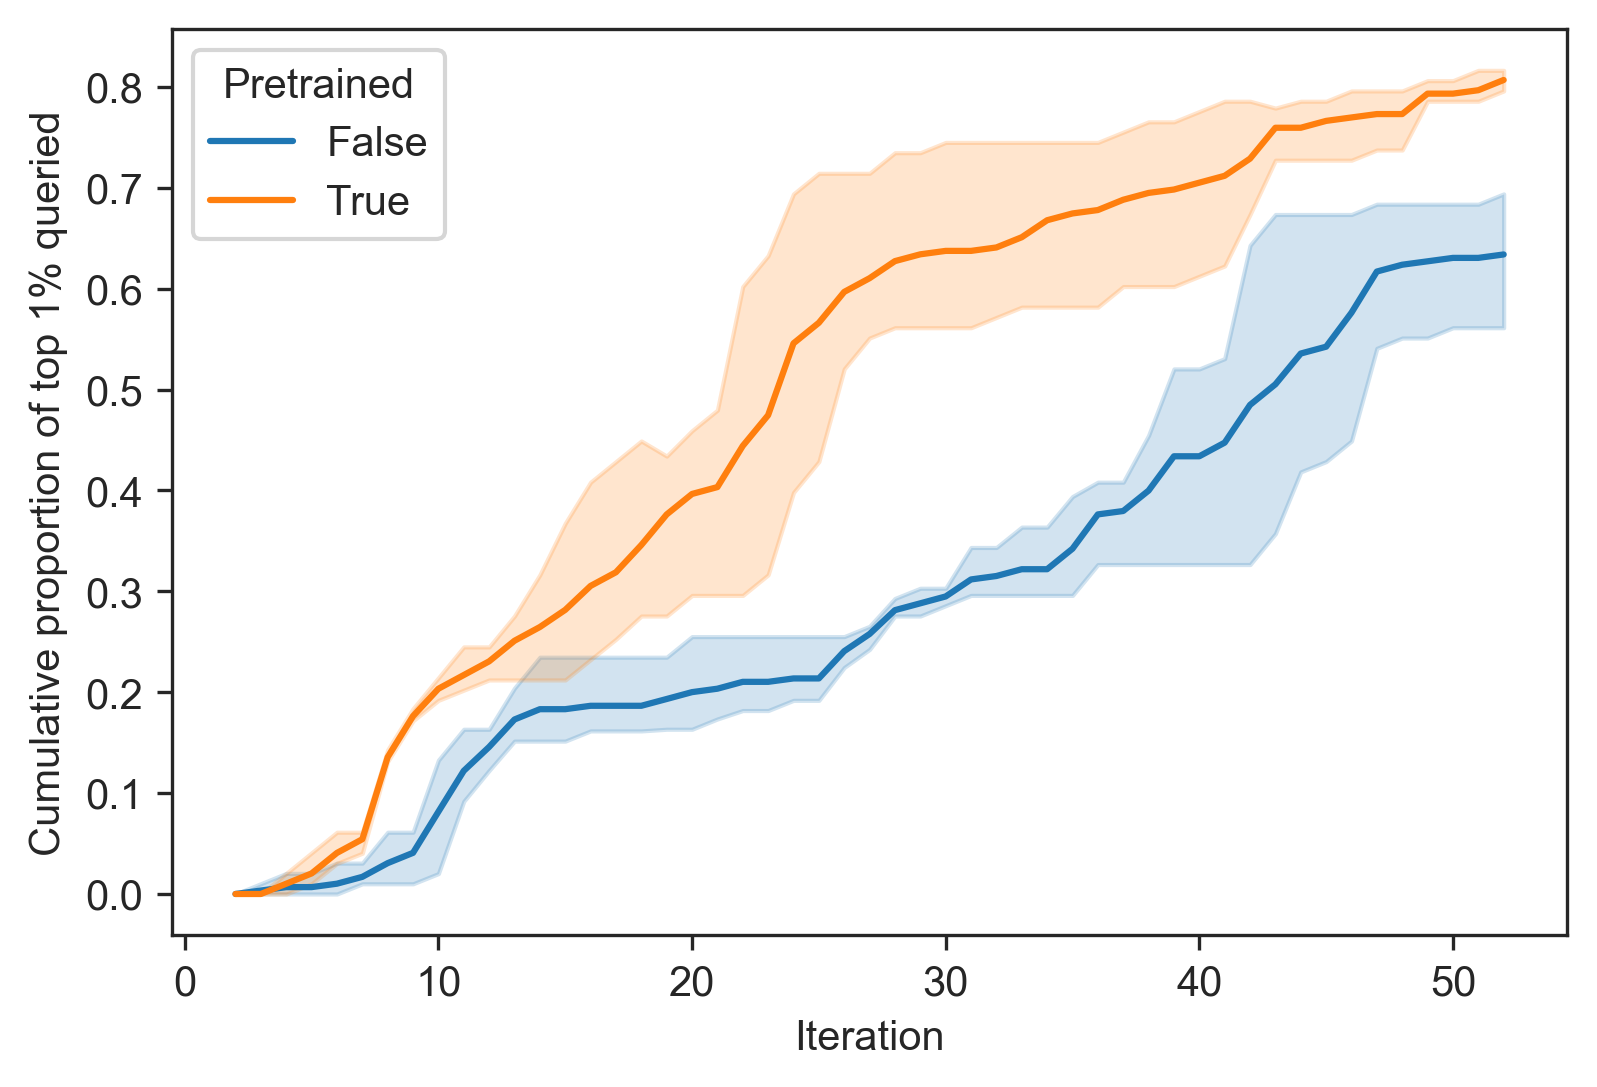

In [15]:
plt.figure(dpi=300)

# All_results = All_results[All_results["Pretrained"].apply(lambda p: not(p))]

sns.lineplot(data=All_results, x="Iteration", 
             y='Cumulative proportion of top 1% queried', hue="Pretrained")
# plt.xlim(0, 20)
plt.show()

## Experiments comparing UCB and Greedy

In [16]:
logdir_list = ["/Users/paul/PycharmProjects/RECOVERcoalition/Recover/RayLogs/active_learning_bliss_av"]

In [17]:
All_results = None

for logdir in logdir_list:
    for directory in os.listdir(logdir):
        if directory.startswith("Active"):
            f = open(os.path.join(logdir, directory, "params.json"))
            params = json.load(f)
            f.close()

            progress = pd.read_csv(os.path.join(logdir, directory, "progress.csv"))

            result = pd.DataFrame(progress['top'])
            result['query_true_syn_mean'] = progress['query_true_syn_mean']
            result['n_unique_drugs_in_query'] = progress['n_unique_drugs_in_query']
            result['query_true_syn_quantile_0.5'] = progress['query_true_syn_quantile_0.5']
            result['query_true_syn_quantile_0.0'] = progress['query_true_syn_quantile_0.0']
            result['query_true_syn_quantile_1.0'] = progress['query_true_syn_quantile_1.0']


            result["n_epoch_between_queries"] = params["n_epoch_between_queries"]
            result["acquire_n_at_a_time"] = params["acquire_n_at_a_time"]
            result["n_initial"] = params["n_initial"]
            result["patience_max"] = params["patience_max"]
            result['load_model_weights'] = params['load_model_weights']
            result['acquisition'] = params['acquisition'].split('.')[-1][:-2]
            result['n_initial'] = params['n_initial']
            result['seed'] = params['seed']
            result['cell_line'] = params['cell_line']
            result['kappa'] = params['kappa']
            result['iterations'] = range(len(result))
            result['val_set_prop'] = params['val_set_prop']
            result['target'] = params['target']

            if All_results is None:
                All_results = result
            else:
                All_results = pd.concat((All_results, result))

In [18]:
All_results = All_results.dropna()
All_results = All_results.reset_index()

All_results = All_results.rename(columns={"top": "Cumulative proportion of top 1% queried", 
                                          "iterations": "Iteration",
                                          "acquisition": "Acquisition",
                                         "query_true_syn_mean": "Average of true synergies in the query",
                                         "load_model_weights": "Pretrained"})

mapping = {"RandomAcquisition": "Brute-Force", "GreedyAcquisition": "Greedy acquisition", "UCB": "UCB acquisition"}

All_results["Acquisition"] = All_results["Acquisition"].apply(lambda s: mapping[s])
All_results["Iteration"] = All_results["Iteration"].apply(lambda s: s + 2)

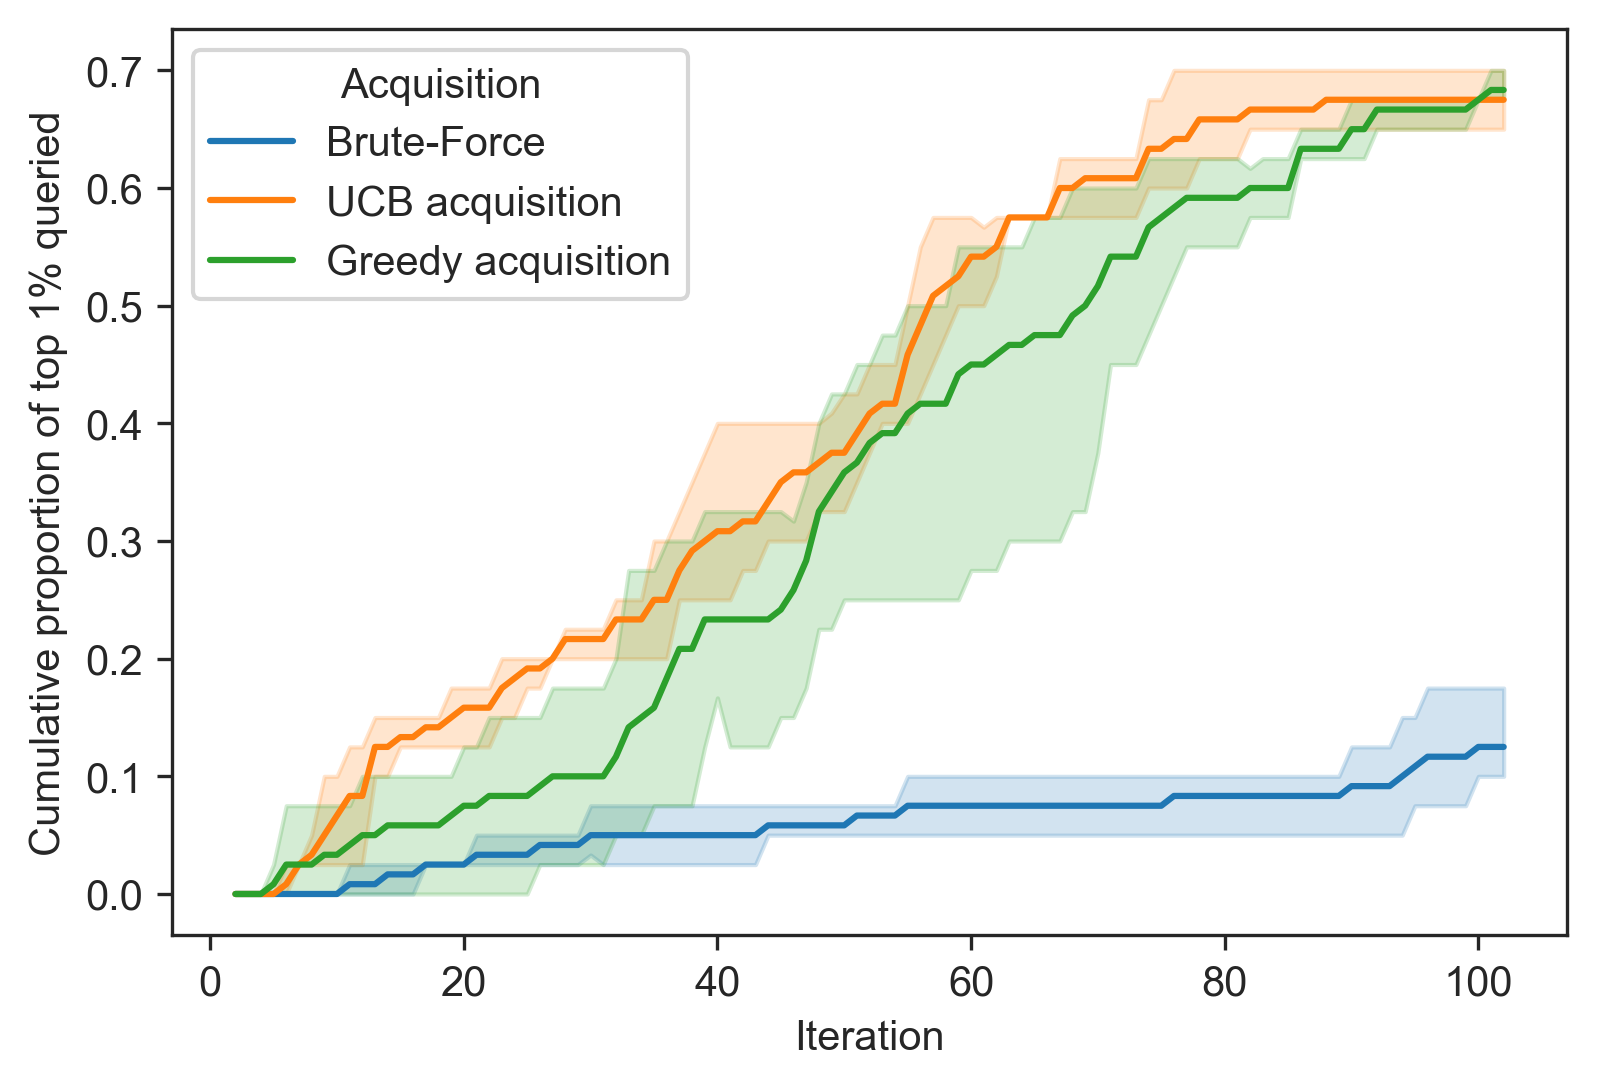

In [19]:
plt.figure(dpi=300)
sns.lineplot(data=All_results, x='Iteration', y="Cumulative proportion of top 1% queried", hue="Acquisition")
plt.show()

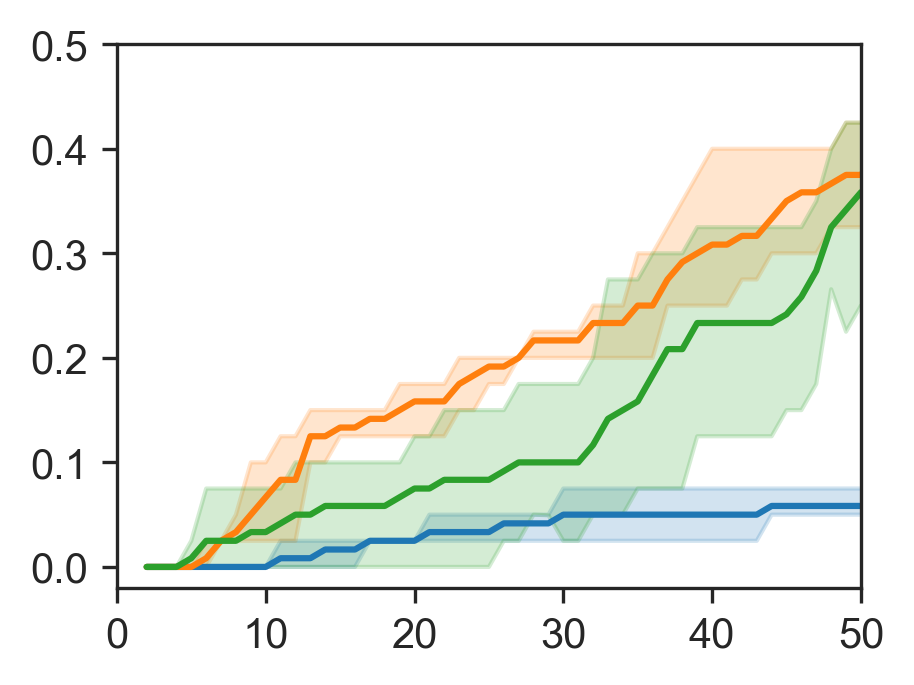

In [20]:
plt.figure(figsize=(3.2, 2.4), dpi=300)
sns.lineplot(data=All_results, x='Iteration', y="Cumulative proportion of top 1% queried", hue="Acquisition")
plt.ylim(-0.02, 0.5)
plt.xlim(0, 50)
plt.xlabel("")
plt.ylabel("")
plt.legend().remove()
plt.show()